#**-------------------------------------TRABALHO PST---------------------------------------**

## **NOTEBOOK 4 | Machine Learning Models**

**Realizado por:**
- David Carvalho, nº2242131
- Lígia Carteado Mena, nº2242194
- Rui Filipe Parada, nº2211025

---------------------------------------------------------
**Dataset escolhido:**
- Foods1_CA4 -> Departamento Foods1 da loja 4 do Estado da Califórnia

## **1. IMPORTS**

In [ ]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.9 MB/s eta 0:00:00


In [ ]:
!pip install mlforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
import io
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import metrics

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from statsforecast import StatsForecast
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## **2. DATA UPLOAD | DIVISÃO TREINO E TESTE**

### Data upload: fazer upload dos ficheiros 'Foods1_CA4.csv' e 'results_PST3'

In [ ]:
uploaded = files.upload()

if 'Foods1_CA4.csv' in uploaded and 'results_PST3.csv' in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded['Foods1_CA4.csv']), parse_dates=['ds'])
    Models_results = pd.read_csv(io.BytesIO(uploaded['results_PST3.csv']), sep=',')
    print("Both files uploaded successfully.")
else:
    print("Please ensure both 'Foods1_CA4.csv' and 'results_PST3.csv' are uploaded.")

df

Saving results_PST3.csv to results_PST3.csv
Saving Foods1_CA4.csv to Foods1_CA4.csv
Both files uploaded successfully.


,unique_id,ds,y
0,FOODS_1_001_CA_4,2011-01-30,1.0
1,FOODS_1_001_CA_4,2011-01-31,1.0
2,FOODS_1_001_CA_4,2011-02-01,1.0
3,FOODS_1_001_CA_4,2011-02-02,1.0
4,FOODS_1_001_CA_4,2011-02-03,1.0
...,...,...,...
355368,FOODS_1_219_CA_4,2016-06-15,2.0
355369,FOODS_1_219_CA_4,2016-06-16,1.0
355370,FOODS_1_219_CA_4,2016-06-17,4.0
355371,FOODS_1_219_CA_4,2016-06-18,0.0


### Conjunto de treino e teste

In [ ]:
train = df[df['ds'] <= '2016-05-22']
train

,unique_id,ds,y
0,FOODS_1_001_CA_4,2011-01-30,1.0
1,FOODS_1_001_CA_4,2011-01-31,1.0
2,FOODS_1_001_CA_4,2011-02-01,1.0
3,FOODS_1_001_CA_4,2011-02-02,1.0
4,FOODS_1_001_CA_4,2011-02-03,1.0
...,...,...,...
355340,FOODS_1_219_CA_4,2016-05-18,3.0
355341,FOODS_1_219_CA_4,2016-05-19,2.0
355342,FOODS_1_219_CA_4,2016-05-20,2.0
355343,FOODS_1_219_CA_4,2016-05-21,6.0


In [ ]:
test = df[df['ds'] > '2016-05-22'].rename(columns={'y': 'y_test'})
test

,unique_id,ds,y_test
1940,FOODS_1_001_CA_4,2016-05-23,2.0
1941,FOODS_1_001_CA_4,2016-05-24,0.0
1942,FOODS_1_001_CA_4,2016-05-25,0.0
1943,FOODS_1_001_CA_4,2016-05-26,6.0
1944,FOODS_1_001_CA_4,2016-05-27,0.0
...,...,...,...
355368,FOODS_1_219_CA_4,2016-06-15,2.0
355369,FOODS_1_219_CA_4,2016-06-16,1.0
355370,FOODS_1_219_CA_4,2016-06-17,4.0
355371,FOODS_1_219_CA_4,2016-06-18,0.0


In [ ]:
train.shape, test.shape

((349325, 3), (6048, 3))

## **3. MODELING**

### Dataset parameters

In [ ]:
freq = 'D'
season_length = 7
horizon = 28

### Instanciar modelos

Os dois modelos de machine learning que serão utilizados são os seguintes:  XGBoost e LightGBM.

In [ ]:
# list of models and instantiation parameters

models = [
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),

    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
]

In [ ]:
mlf = MLForecast(
    models=models,
    freq=freq,
    lags = [1,7,28]
)

In [ ]:
mlf.preprocess(train)

,unique_id,ds,y,lag1,lag7,lag28
28,FOODS_1_001_CA_4,2011-02-27,0.0,1.0,0.0,1.0
29,FOODS_1_001_CA_4,2011-02-28,0.0,0.0,1.0,1.0
30,FOODS_1_001_CA_4,2011-03-01,1.0,0.0,0.0,1.0
31,FOODS_1_001_CA_4,2011-03-02,1.0,1.0,1.0,1.0
32,FOODS_1_001_CA_4,2011-03-03,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
355340,FOODS_1_219_CA_4,2016-05-18,3.0,2.0,1.0,3.0
355341,FOODS_1_219_CA_4,2016-05-19,2.0,3.0,0.0,0.0
355342,FOODS_1_219_CA_4,2016-05-20,2.0,2.0,1.0,2.0
355343,FOODS_1_219_CA_4,2016-05-21,6.0,2.0,2.0,2.0


In [ ]:
mlf.fit(train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 343277, number of used features: 3
[LightGBM] [Info] Start training from score 1.006400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

MLForecast(models=[XGBRegressor, LGBMRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag28'], date_features=[], num_threads=1)

In [ ]:
forecasts = mlf.predict(h=horizon)
forecasts.head()

,unique_id,ds,XGBRegressor,LGBMRegressor
0,FOODS_1_001_CA_4,2016-05-23,0.245742,0.246575
1,FOODS_1_001_CA_4,2016-05-24,0.503096,0.780536
2,FOODS_1_001_CA_4,2016-05-25,0.604036,0.805931
3,FOODS_1_001_CA_4,2016-05-26,0.604036,0.805931
4,FOODS_1_001_CA_4,2016-05-27,0.245742,0.677900


In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'], suffixes=('_test', '_forecast'))

In [ ]:
cv_ml = mlf.cross_validation(df=train,
                             n_windows=1,
                             step_size=horizon,
                             h=horizon)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 337229, number of used features: 3
[LightGBM] [Info] Start training from score 1.002426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## **5. ANÁLISE DAS MÉTRICAS**

In [ ]:
def rmsse(y, y_hat, y_train, seasonality):
    delta_y = (y - y_hat) ** 2
    delta_y = np.average(delta_y)
    scale = (y_train[:-seasonality] - y_train[seasonality:]) ** 2
    scale = np.average(scale)
    rmsse = np.sqrt(delta_y / scale)
    return rmsse

def mase(y, y_hat, y_train, seasonality):
    delta_y = abs(y - y_hat)
    delta_y = np.average(delta_y)
    scale = abs(y_train[:-seasonality] - y_train[seasonality:])
    scale = np.average(scale)
    mase = delta_y / scale
    return mase

def model_evaluation(y_hist, y_true, y_pred, Model, seasonality):

    results_row = [{"Model": Model,
                    "MSE": metrics.mean_squared_error(y_true, y_pred),
                    "MAE": metrics.mean_absolute_error(y_true, y_pred),
                    "RMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
                    "RMSSE": rmsse(y_true.values, y_pred.values, y_hist.values, seasonality=seasonality),
                    "MASE": mase(y_true.values, y_pred.values, y_hist.values, seasonality=seasonality)
                   }]

    results = pd.DataFrame.from_records(results_row)
    return results

In [ ]:
### FAZER DOWNLOAD DO FICHEIRO 'results_PST4.csv' NA ABA FICHEIROS DO COLAB ###

new_result = model_evaluation(train["y"], test["y_test"], test["XGBRegressor"], "XGBoost", season_length)
Models_results = pd.concat([Models_results, new_result], ignore_index=True)

new_result = model_evaluation(train["y"], test["y_test"], test["LGBMRegressor"], "LightGBM", season_length)
Models_results = pd.concat([Models_results, new_result], ignore_index=True)

Models_results.to_csv("results_PST4.csv", index=False)

Models_results

,Model,MSE,MAE,RMSE,RMSSE,MASE
0,Seasonal Naive,4.866237,1.268023,2.205955,1.055169,1.228272
1,Historic Average,3.181790,1.069713,1.783757,0.853221,1.036179
2,AutoARIMA,2.778064,1.043241,1.666753,0.797254,1.010537
3,AutoETS,2.722531,1.036994,1.650009,0.789245,1.004485
4,XGBoost,3.275633,1.053321,1.809871,0.865711,1.020301
5,LightGBM,3.013774,1.134485,1.736022,0.830388,1.098920


Os modelos estatísticos clássicos com ajuste automático (ETS e ARIMA) são mais adequados do que os de machine learning, provavelmente porque captam bem a estrutura temporal e a sazonalidade dos dados.

### Plot das previsões

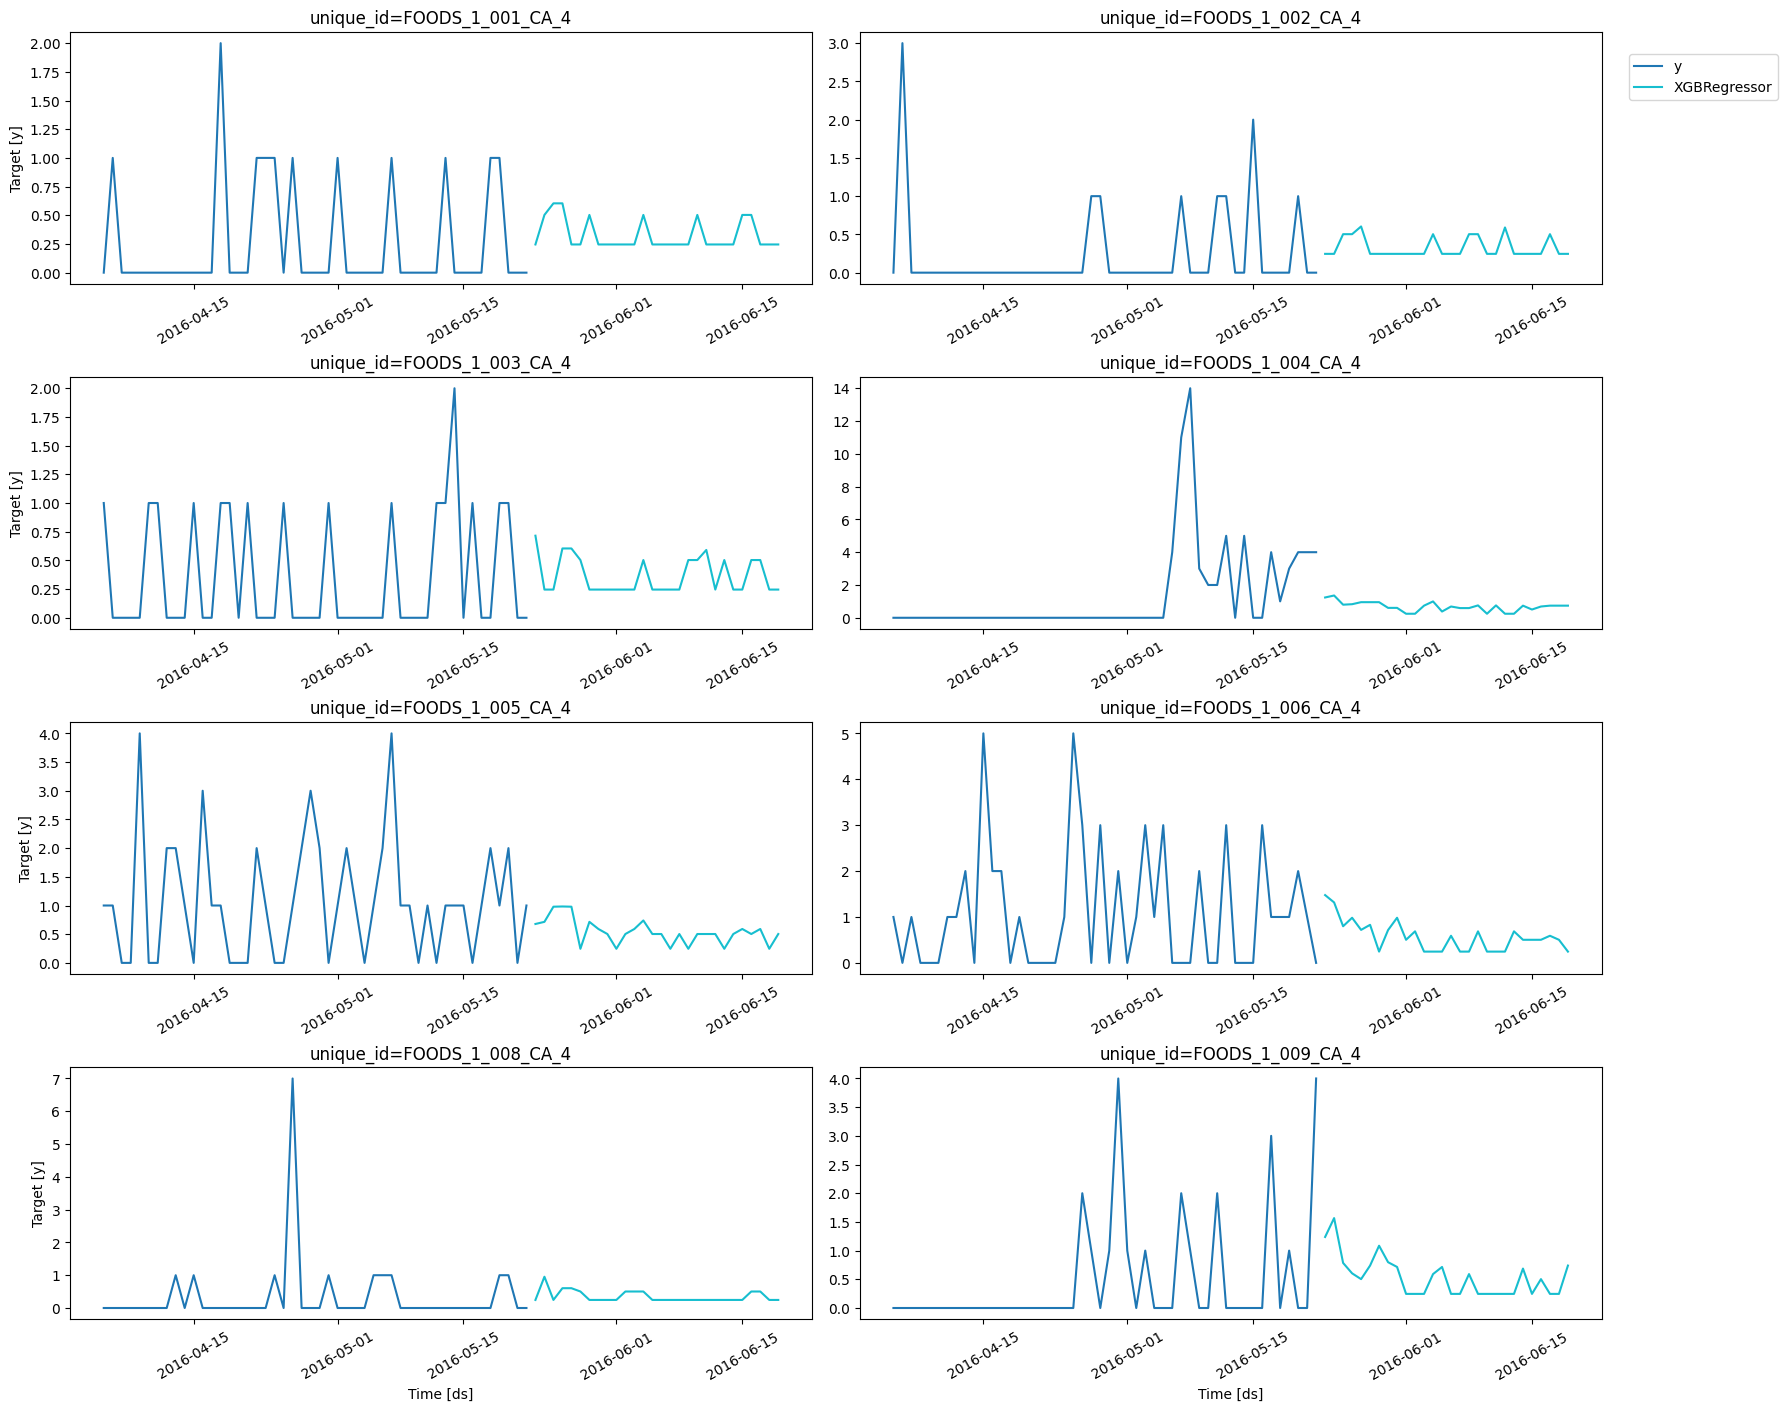

In [ ]:
plot_series(
    train,
    test,
    plot_random=False,
    models=['XGBRegressor'],
    max_insample_length=48
)

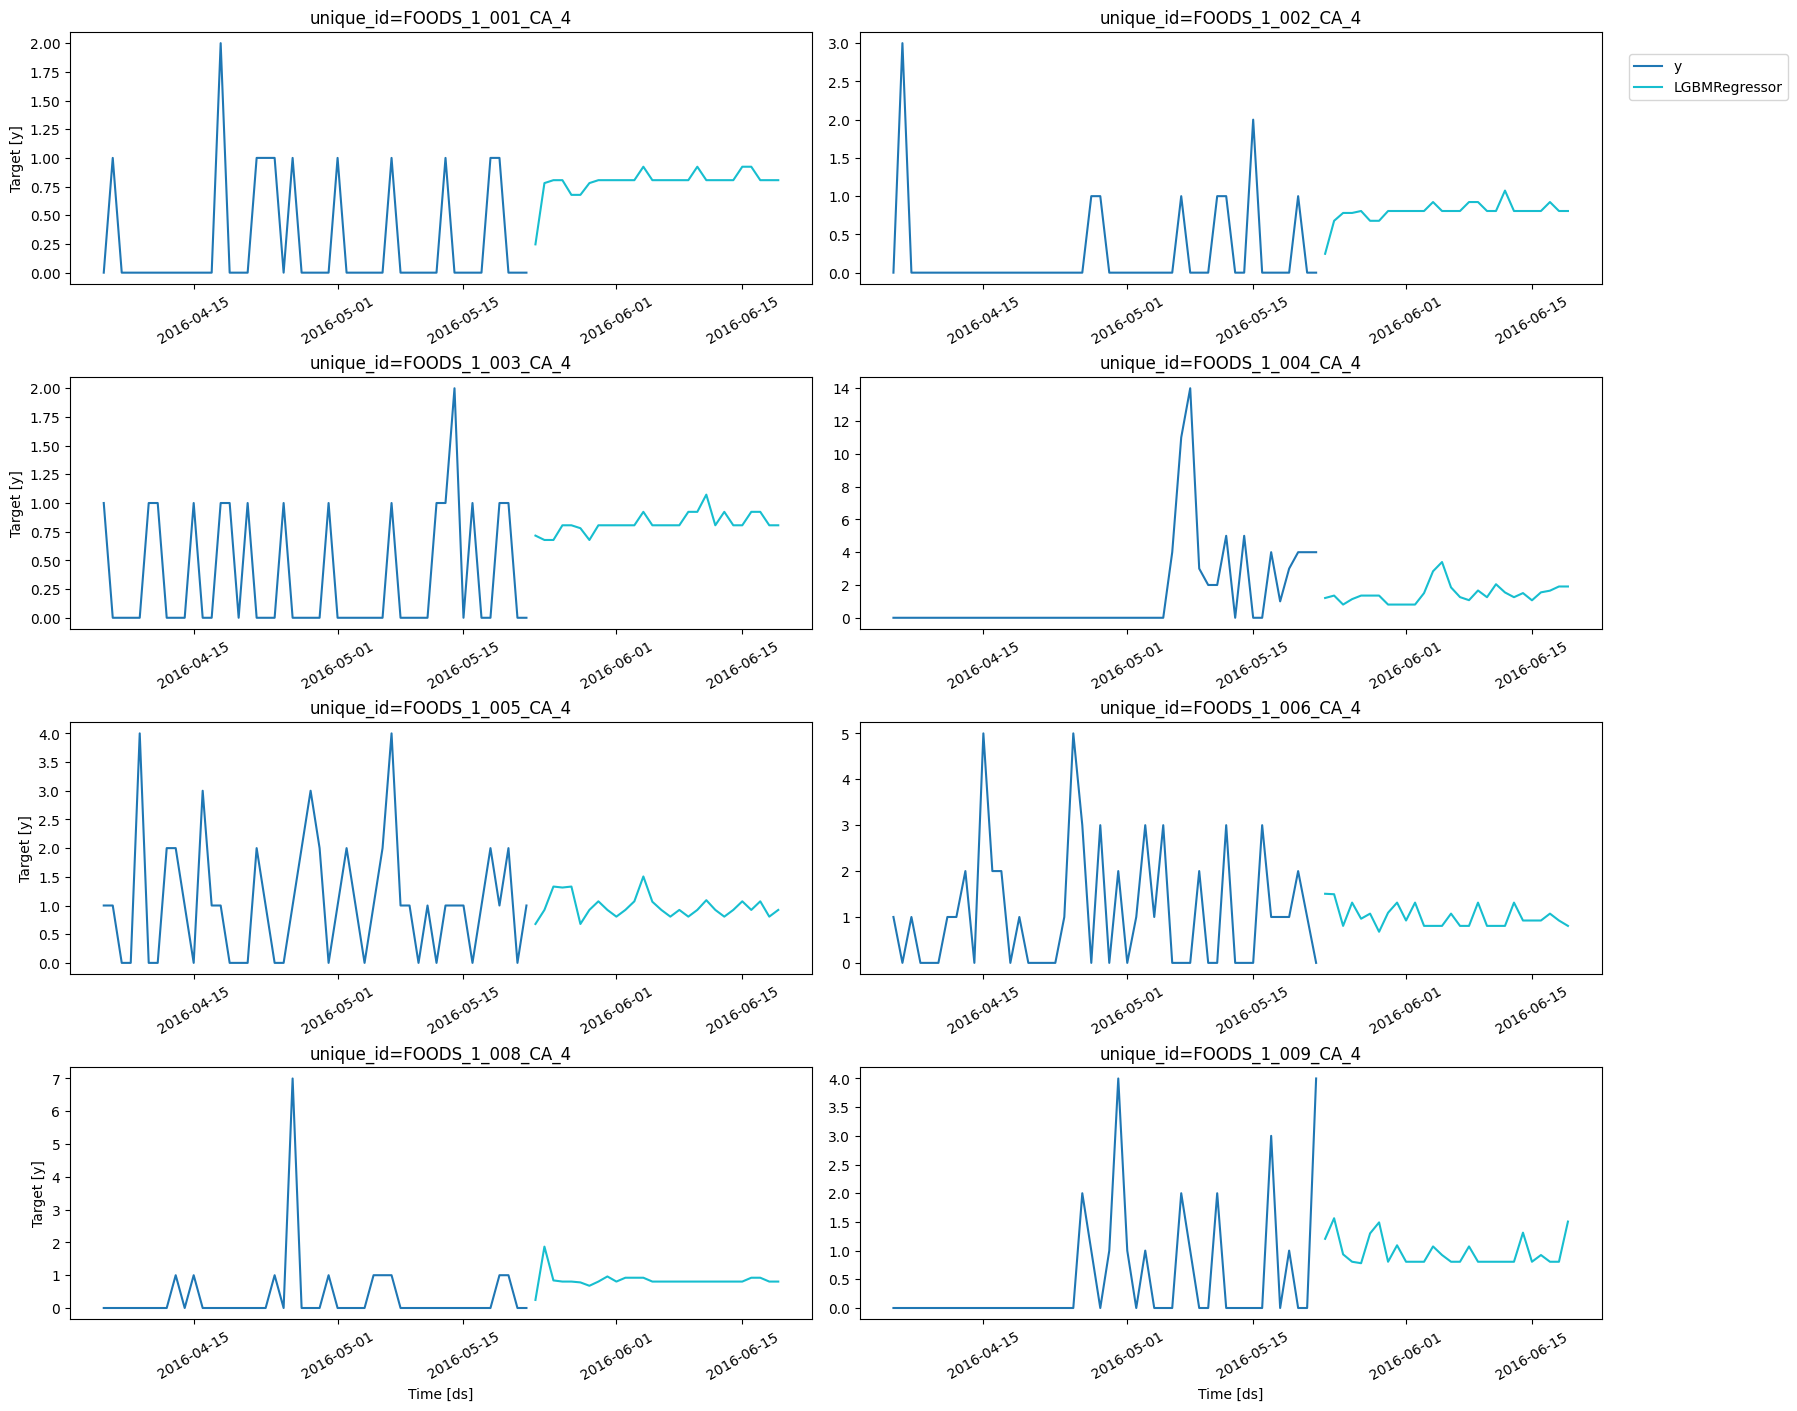

In [ ]:
plot_series(
    train,
    test,
    plot_random=False,
    models=['LGBMRegressor'],
    max_insample_length=48
)